In [228]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import seaborn as sns
print "... python ready"

# there are three data files covering three different kinds of war
interstate_wars = pd.read_csv('interstate.csv')
intrastate_wars = pd.read_csv('intrastate.csv')
#extrastate_wars = pd.read_csv('intrastate.csv')

# Why is 'extrastate_wars' being excluded?
# These are battles between a non-state actor and some state
# other than the one in which the battle takes place, such as the US
# battling the Iraqi Resistance in Iraq or Israel battling Palestinian militias. 
# In these cases, the affected populations are not assignable to any of the
# named participants.  Although a knowledgable observer of the data will 
# likely know what state or territory these populations belong to, I am only
# knowledgable enough to fill in that information in a small number of cases.
# This is unfortunate because it's the only place we get civilian casualty numbers.
#extrastate_wars = pd.read_csv('extrastate.csv')

interstate_wars.drop(0, inplace=True)
intrastate_wars.drop(0, inplace=True)


# making a usable population table (data from wikipedia)
# https://en.wikipedia.org/wiki/List_of_countries_by_past_and_future_population
populations = pd.read_csv('populations.csv')
w = populations.T
w.columns = w.iloc[0]
w.reset_index(inplace=True)
w.drop(0, inplace=True)
w.set_index('index', inplace=True)
w.index = w.index.map(int)
for c in w.columns:
    w[c] = w[c].map(int)

# the wikipedia data only has values every 5 years, so fill in the blanks.
# interpolated values are adequate here
w = w.reindex(range(1950, 2008))
w = w.interpolate(method='linear')

print '... data ready'

... python ready
... data ready


In [229]:
# for reference
intrastate_cols = ['war_id', 'war_name', 'war_type', 'side1_code', 'side1_name', \
                   'side2_code', 'side2_name', 'start_year1','combat_location', \
                   'side1_fatalities', 'side2_fatalities', 'outcome']

interstate_cols = ['war_id', 'war_name', 'war_type', 'state_code', \
                   'state_name', 'side', 'start_year1',\
                  'combat_location', 'combat_fatalities', 'outcome']


# make it possible to see where things came from in the merged 'allwars' table
intrastate_wars['file'] = "intrastate_wars"
interstate_wars['file'] = "interstate_wars"

# getting fatality totals per side for each war
interstate_wars['deaths'] = interstate_wars['combat_fatalities']

# While rebel forces may be from another country, INTRA-state wars are
# civil wars so we're counting all deaths as belonging to the country
# named in side1_name.  When both casualty counts exist, side1_name is
# the host country. When they don't (-8 below, for example), side1_name
# is a foreign power and the calculation will be off, but only by single digits

#   war_name         |  side1_name     |  side2_name  | side1_fatalities  | side2_fatalities
#--------------------|-----------------|----------------------------------|----------
#   Vietnam Phase 1  |  Vietnam        |  NLF         | 23300             | 76900
#   Vietnam Phase 1  |  United States  |  -8          | 506               | -8
intrastate_wars['deaths'] = intrastate_wars['side1_fatalities'] \
                            + intrastate_wars['side2_fatalities']
    
# making one war table
allwars = pd.concat([interstate_wars, intrastate_wars])  
allwars.rename(columns={'start_year1':'year'}, inplace=True)

# Each row describes a pair of combatants in a war, but many wars have more than two.
# Thus wars can appear more than once.  To get total war deaths for all countries
# involved, we have to add them up.  will fill the values in the allwars table in 
# the loop below
allwars['participants'] = np.nan
allwars['cumdeaths'] = np.nan
pcounts = allwars[['war_name', 'deaths']].groupby('war_name').size() # how many participants
pdsums  = allwars[['war_name', 'deaths']].groupby('war_name').sum()  # the sum of all casualties

# a few more columns to fill while looping
allwars['localpain'] = np.nan  # will be (fatalities on a given side)/(population of that side)
allwars['dotpop']    = np.nan  # will be population per country/year

# the population data from wikipedia starts in 1950.  This is as good an excuse 
# as any (though there are other good reasons) to look only at post-WWII wars
allwars = allwars[(allwars.year >= 1950)].sort_values('year')

# Reseting index temporarily to make it easy to fold in the 
# world population values, which are indexed by year
allwars.set_index('year', inplace=True)
allwars['worldpop'] = w.world 

# but now we need unique indexes again, or else the set_value lines below
# will change more values than we want them to
allwars['year_of_war'] = allwars.index
allwars = allwars.reset_index(range(len(allwars)))

# mapping a few odd names to the values in the population file to make that data usable,
# in the process fixing some mispelings and tipos
renamings = {'USSR': 'Russia', 'Taiwan (ROC)': 'Taiwan', 'China (PRC)': 'China', \
             'Bosnia':'Bosnia and Herzegovina', 'United States of America': 'United States',\
            'Phillippines':'Philippines', 'Yemen Arab Republic':'Yemen', \
             'Vietnam, Republic of':'Vietnam','Egypt/United Arab Republic':'Egypt',\
             'Burma':'Myanmar','Congo':'Democratic Republic of the Congo', 'Lebanese Forces':'Lebanon',\
            'Zaire':'Democratic Republic of the Congo', 'Congo (Brazzaville)':'Republic of the Congo',\
            'Guinea ':'Guinea', 'Nepal ':'Nepal', 'Cote d\'Ivoire':'Ivory Coast',\
            'Yemen People\'s Republic':'Yemen', 'Republic of Congo':'Republic of the Congo',\
             'Democratic Republic of Congo':'Democratic Republic of the Congo',\
            'Yugoslavia/Serbia':'Serbia', 'Tadzhikistan':'Tajikistan', \
             'DRC':'Democratic Republic of the Congo', 'Vietnam, Democratic Rep.':'Vietnam'}
for key, value in renamings.iteritems():
    allwars = allwars.set_value(allwars.loc[allwars.state_name == key].index, 'state_name', value)
    allwars = allwars.set_value(allwars.loc[allwars.side1_name == key].index, 'side1_name', value)
    allwars = allwars.set_value(allwars.loc[allwars.side2_name == key].index, 'side2_name', value)


for index, row in allwars.iterrows():
    # number of participants in any given war
    allwars = allwars.set_value\
             (index, 'participants', pcounts[pcounts.index == row['war_name']].iloc[0])
        
    # total dead in that war on all sides
    allwars = allwars.set_value\
             (index, 'cumdeaths', pdsums[pdsums.index == row['war_name']].iloc[0])
        
    # Only the 'interstate_wars' file has a 'state_name' column, so filtering
    # 'allwars' for that column selects the data from that file.
    thisyear = row['year_of_war']
    if thisyear < 1950: thisyear = 1950
    if pd.notnull(row['state_name']):
        cpop = w[row['state_name']][w.index == thisyear].iloc[0]
        allwars = allwars.set_value(index, 'localpain', row['deaths']/cpop)
        allwars = allwars.set_value(index, 'dotpop', cpop)
    elif row['file'] == 'intrastate_wars':
        # side1_name is the country in which the war/revolution/insurgency takes 
        # place. Side2_name is the rebel forces (but can also be a state supporting
        # the rebel forces).  Check that there's population data for side1 before proceeding.
        # If side1 doesn't match a named state, but side2 does, run that instead
        bcount = row.side1_fatalities + row.side2_fatalities
        if row['side1_name'] in w.columns:
            cpop = w[row['side1_name']][w.index == thisyear].iloc[0]
            allwars = allwars.set_value(index, 'localpain', row['deaths']/cpop)
            allwars = allwars.set_value(index, 'dotpop', cpop)
        else:
            if row['side2_name'] in w.columns:
                cpop = w[row['side2_name']][w.index == thisyear].iloc[0]
                allwars = allwars.set_value(index, 'localpain', row['deaths']/cpop)
                allwars = allwars.set_value(index, 'dotpop', cpop)

# measures how much of the world's population is lost to war 
allwars['globalpain'] = allwars.cumdeaths/allwars.worldpop

print "... allwars table ready"

... allwars table ready


In [230]:
def fig1():
    fig, ax = plt.subplots(1,1, figsize=(20,5))
    sns.barplot(x='year_of_war', y='globalpain', data=allwars, ax=ax);
    sns.pointplot(x="year_of_war", y=((allwars.worldpop - allwars.worldpop.min())/10000000), \
              data=allwars, ax=ax, scale=.4)
    ax.set_title('all war deaths by year / global population of that year')
    ax.xaxis_date()
    fig.autofmt_xdate()

    fig, ax = plt.subplots(1,1, figsize=(20,5))
    sns.barplot(x='year_of_war', y='cumdeaths', data=allwars);
    ax.set_title('all war deaths by year')
    ax.xaxis_date()
    fig.autofmt_xdate()


Background

The Correlates of War project aims to collect data relevant to the understanding of war.  They collect data about, among other things, religion, military capacity and war history.  I will be focusing on casuatly counts.  

I'm particularly interested in the emotional impact of casualties.  Thus, in many of the plots below, war deaths are divided by population numbers in an effort to measure that impact.  This first pair of plots looks at global war deaths in each given year divided by the global population of that year.

<hr>

War casualties by year between 1950 and 2007

The spikes below are mostly due to the Korean war starting in 1950, the 
Vietnam war starting in 1965 and the Iran-Iraq war starting in 1980.

Showing casualties adjusted for global population, which has more than doubled from a base of 2.5 billion in 1950, gives the affect of declining casualties over time, though it's a fair question whether that maps to any real subjective experience.

The dotted line shows global population growth.

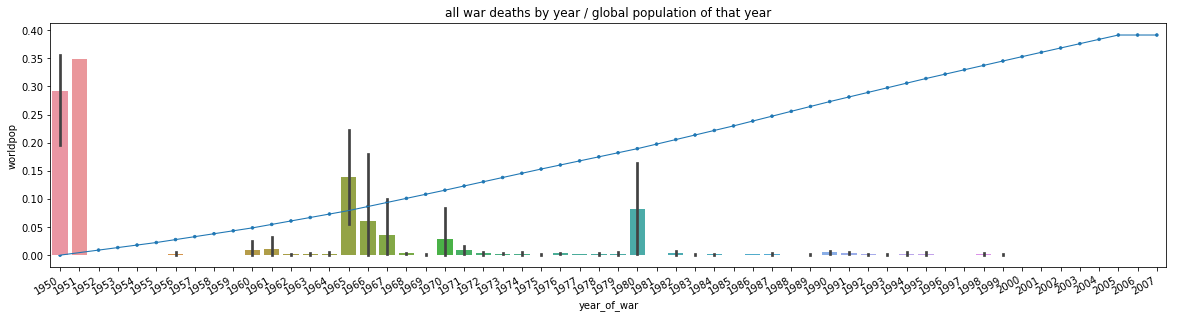

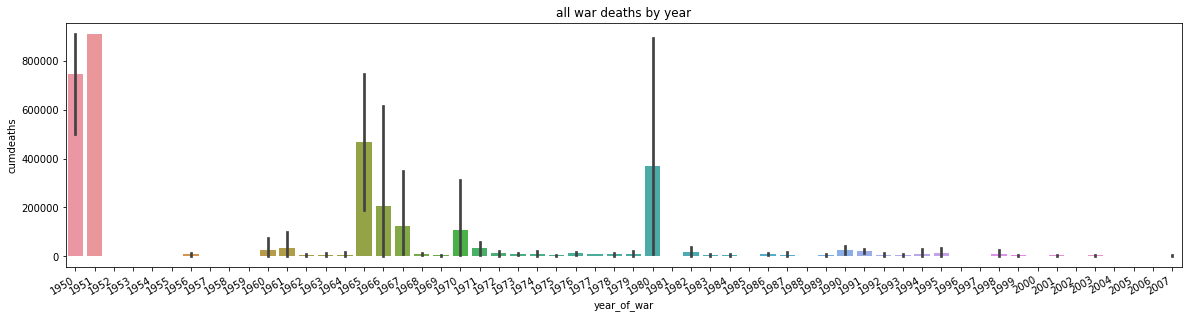

In [231]:
fig1()

In [232]:
def fig2():
    inter = allwars[(allwars.year_of_war >= 1950) & (allwars.cumdeaths < 400000) \
                    & (allwars.localpain > .00001)].sort_values('war_name')

    fig, axs = plt.subplots(1,2, figsize=(26,36))
    
    # localpain is per country, but the bar chart summarizes the values.  Notice that
    # error bars appear on the left plot below, but not on the right, because
    # the 'cumdeath' values are all the same per war, whereas the 'localpain'
    # values are different for each country in that war
    sns.barplot(y='war_name', x='localpain', data=inter, ax=axs[0]);
    axs[0].set_title('per war deaths / affected country populations')

    sns.barplot(y='war_name', x='cumdeaths', data=inter, ax=axs[1]);
    axs[1].set_title('per war deaths (absolute numbers)')

    # there is some control over these
    axs[0].set_position([.01, .125, .15, .7], which='both')
    axs[1].set_position([.30, .125, .15, .7], which='both')
    p = axs[0].get_position()
    pp = axs[1].get_position()

Zooming in, how do these numbers look/feel from the point of view of the directly impacted populations?

Whereas the plots above aggregated casualties and impact by year, the plots below do so for each individual war. Also, instead of looking at casualties in relation to the global population of the time, the left plot below looks at casualties in relation to the populations of the countries involved.  The right plot shows total deaths in each war.

----------

~ I've removed the Vietnam, Korean and Iran-Iraq wars from these plots to make the others
more visible.

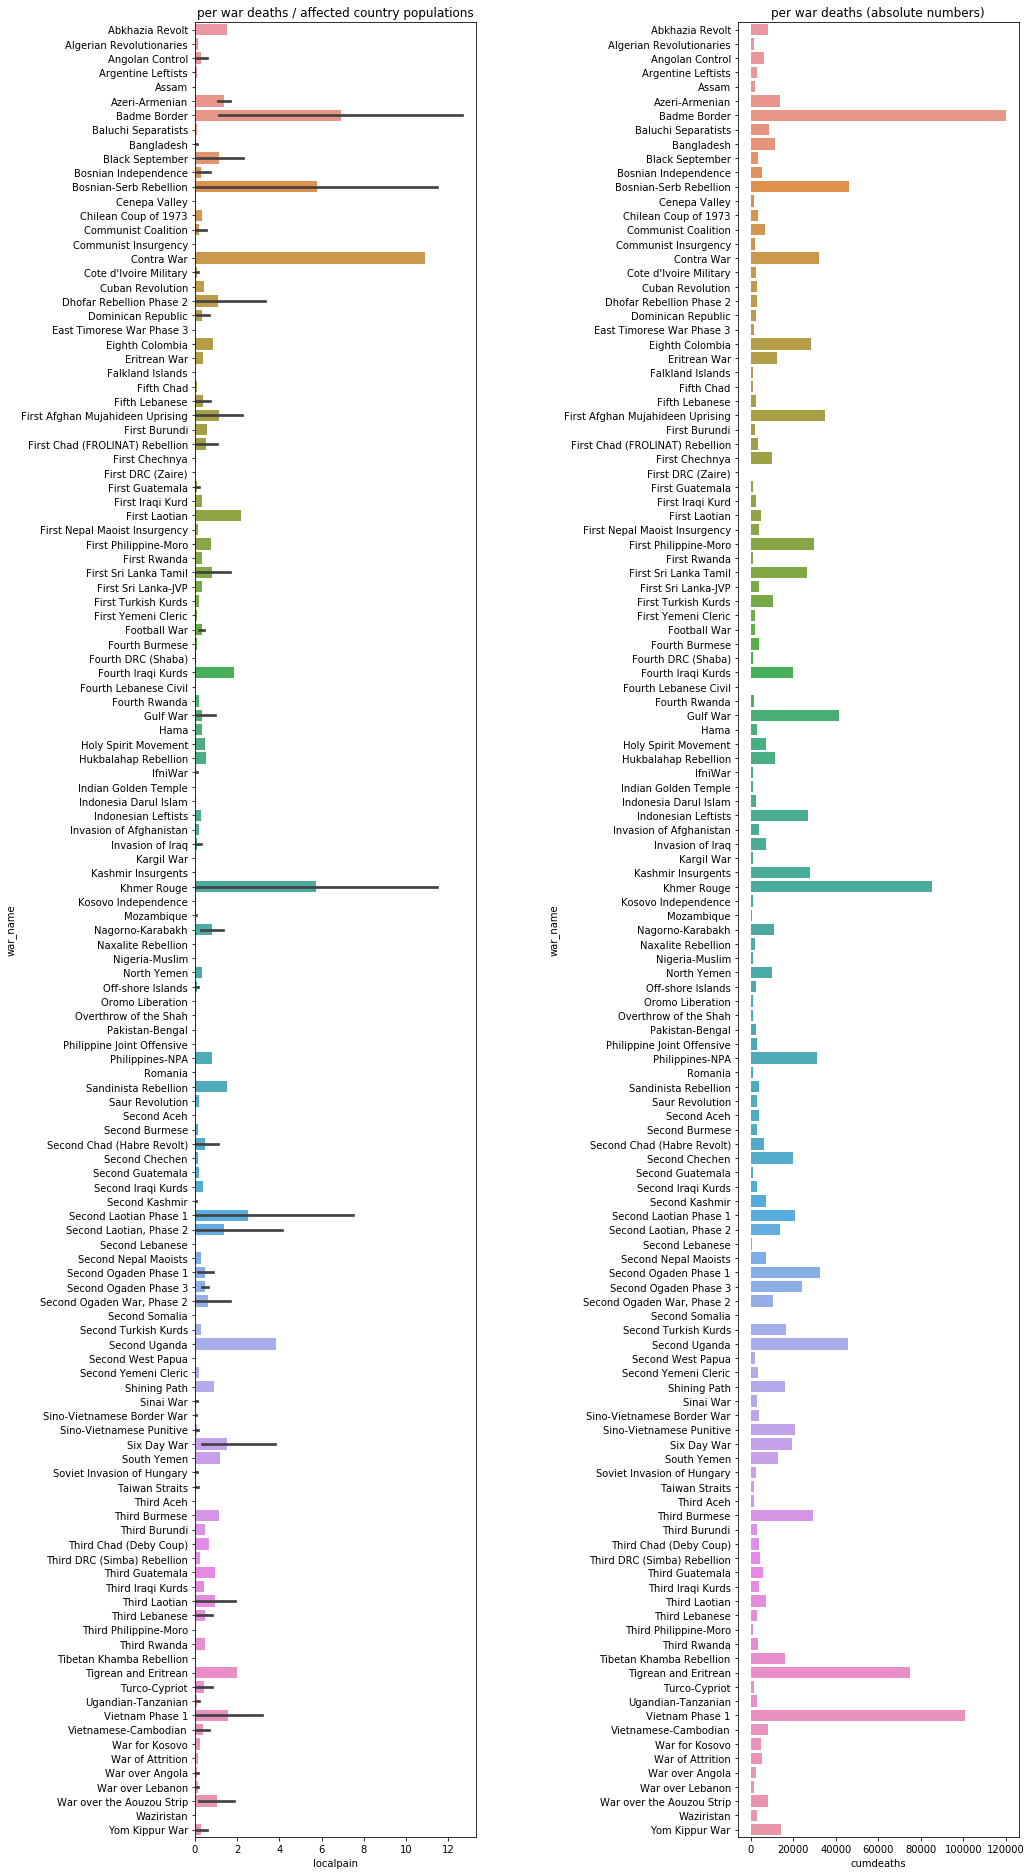

In [233]:
fig2()

In [234]:
# finally getting around to pushing side1_name values into state_name.  
indices1 = allwars[(allwars.side1_name.isin(w.columns)) & (allwars.state_name.isnull())].index
s1names = allwars[(allwars.side1_name.isin(w.columns)) & (allwars.state_name.isnull())].side1_name
allwars = allwars.set_value(indices1, 'state_name', s1names)

# a few stragglers hiding in side2_name.
indices2 = allwars[(allwars.side1_name.str.contains('\d')) & (allwars.side2_name.isin(w.columns))\
                                                           & (allwars.state_name.isnull())].index

s2names = allwars[(allwars.side1_name.str.contains('\d')) & (allwars.side2_name.isin(w.columns))\
                                                           & (allwars.state_name.isnull())].side2_name
allwars = allwars.set_value(indices2, 'state_name', s2names)


inter = allwars[ (allwars.year_of_war >= 1950)].sort_values('state_name')
                
def fig3():
    fig, ax = plt.subplots(1,1, figsize=(12,20))
    sns.barplot(y='state_name', x='localpain', data=inter);
    ax.set_title('per country deaths / individual country population - all wars in the period');


Looking at the data by country, instead of by named war, gives another view.
This plot sums up the experience, for each country, of all the wars fought during the 
period between 1950 and 2007.

Of the plots we've seen so far, this one probably gives the purest picture of the impact of war during this period on individual countries.

<hr>
~ Eritrea and Ethiopia, serendipitously next to each other below, had a border war called the Badme Border War in 1998.  Casualty numbers were small enough for it to not be excluded from the two plots above but the local trauma, as seen below, was comparable to some of the worst wars of this period.


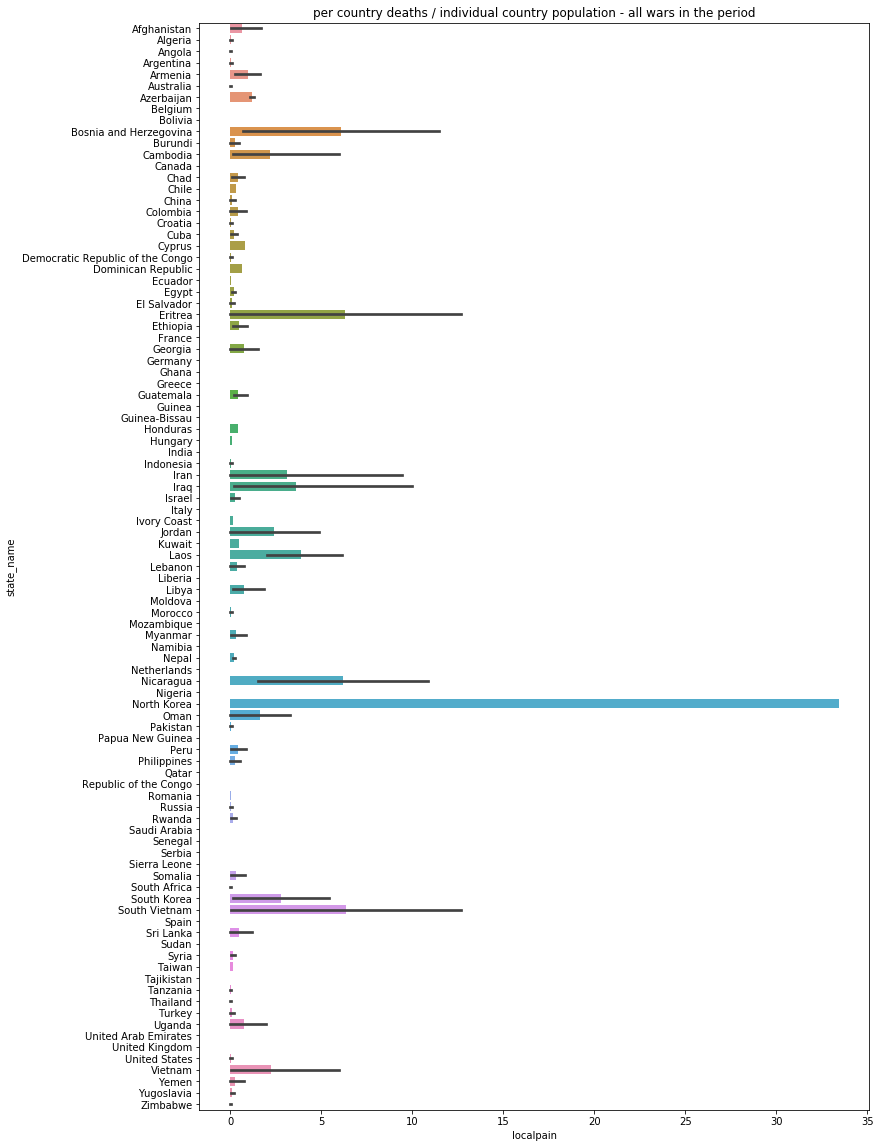

In [235]:
fig3()

In [236]:
def fig4():
    fig, axs = plt.subplots(1,2, figsize=(12,6))

    inter = allwars[(allwars.year_of_war >= 1950)]
    sns.regplot(x="cumdeaths", y="participants", data=inter, scatter_kws={'s':4}, ax=axs[0]);

    inter = allwars[(allwars.year_of_war >= 1950) & (allwars.cumdeaths < 400000) \
                    & (allwars.localpain > .00001)].sort_values('war_name')
    sns.regplot(x="cumdeaths", y="participants", data=inter, scatter_kws={'s':4},ax=axs[1]);

Many wars have multiple participants.  How many wars had more than two
participants?  Is there a relationship between casualty counts and the number
of countries involved?

Again, the Korean, Vietnam and Iran-Iraq wars dominate the casualty counts and make the rest hard to see.  The plot on the right excludes them, although it should be remembered that the two asian wars were both coalition wars and that Iraq had the US as an external sponsor in its war with Iran, all of which supports the thesis. 

Most wars do not approach the scale of these examples, however, and it seems fair to say that, among the smaller wars, the opposite of the thesis is true.  More participants is actually associated with fewer casualties.

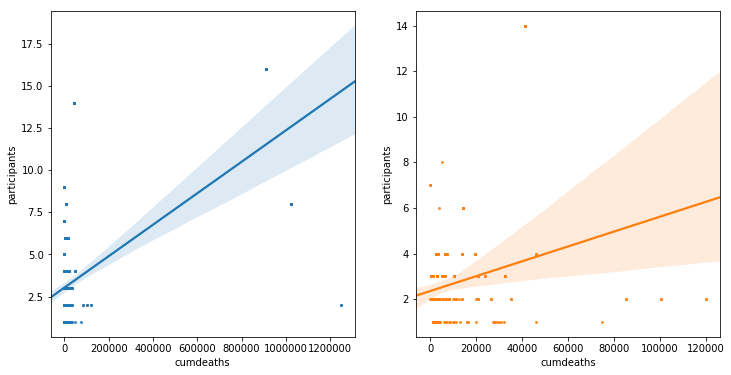

In [237]:
fig4()

In [238]:
# note that the x values in the scatter plot code below are 'deaths', not 'cumdeaths'
# because those deaths are being summed over groups here
def fig5():
    ax = allwars[['war_name','deaths','dotpop']].groupby('war_name').sum()\
            .plot(kind='scatter', x='deaths', y='dotpop')
    ax.set_title("All deaths in the war vs the sum of populations of countries involved")
    ax.set_xlabel('cumdeaths')
    ax.set_ylabel('sum of populations of countries involved')
    
    ax2 = allwars[['war_name','deaths','dotpop']]\
          [allwars.cumdeaths < 400000]\
           .groupby('war_name').sum().plot(kind='scatter', x='deaths', y='dotpop')
    ax2.set_title("Same as above, excluding the three largest wars")
    ax2.set_xlabel('cumdeaths')
    ax2.set_ylabel('sum of populations of countries involved')
    
    ax3 = allwars[['war_name','deaths','dotpop']]\
          [(allwars.participants < 3) & (allwars.cumdeaths < 400000)]\
            .groupby('war_name').sum().plot(kind='scatter', x='deaths', y='dotpop')
    ax3.set_title("Same as above excluding wars with more than 2 participants")
    ax3.set_xlabel('cumdeaths')
    ax3.set_ylabel('sum of populations of countries involved')

The plots below look at the combined populations of all the states involved in a given war vs. the total deaths from that war.  The goal is not to measure pain this time but to ask if casualty numbers are related in a simple way to country population sizes.  

The second plot below excludes the three largest wars of the period and the third one excludes the wars that have more than 2 participants.

The answer, again, is not simple.  Large coalition wars, most of which involve populous countries and take place in relatively populous countries, seem to produce the most casualties.  They're in a class of their own in this regard.  But the relationship between size and casualties doesn't seem to hold true when the large-coalition, very high casualty wars are excluded.  Excluding these power-balance-wars, greater populations of the parties involved does not seem to mean that there will be higher casualties.

On the contrary, for these more common wars, death tolls rarely exceed 30k regardless of the populations of the parties involved.  It may be that losses have more to do with the physcial size of the territory, the number of cities fought over or something similar. 

<hr>
~ population numbers are in thousands

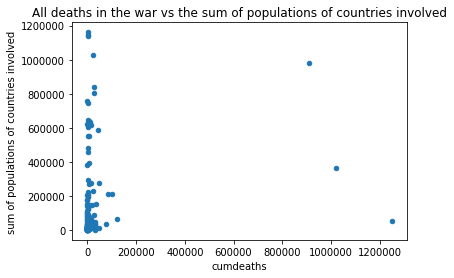

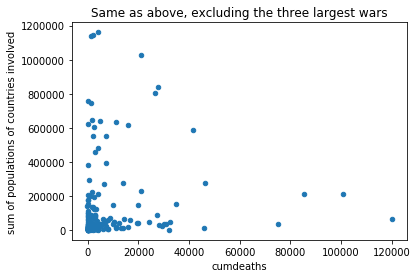

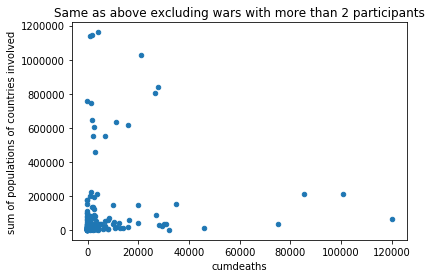

In [239]:
fig5()

In [240]:
#allwars[['state_name', 'side1_name', 'side2_name', 'dotpop', 'localpain', 'deaths', 'cumdeaths', 'war_name']]\
#[allwars.state_name == 'South Africa']

In [291]:
coalition_wars = allwars[['war_name','state_name','participants','dotpop', 'cumdeaths', 'deaths']]\
                                    [(allwars.state_name.notnull()) & (allwars.participants > 2)  \
                                   & (allwars.cumdeaths > 10)].drop_duplicates()

cd = coalition_wars.pivot_table(index='state_name', columns='war_name', values='deaths')
cd.dropna(how='all', inplace=True)
    
cp = coalition_wars.pivot_table(index='state_name', columns='war_name', values='dotpop')
cp.dropna(how='all', inplace=True)
cdp = cd/cp
    
def fig55():
    rw = 0
    cl = 0
    fig, axs = plt.subplots(9,3, figsize=(20,40))
    fig.subplots_adjust(wspace=.5)
    for cc in cd.columns:
        plotdeaths = cd[cc].to_frame()[cd[cc].notnull()]
        plotpain   = cdp[cc].to_frame()[cdp[cc].notnull()]
        
        #if cc == 'Angolan Control': print plotdeaths
        #if cc == 'Angolan Control': print plotpain
        
        plotdeaths.rename(columns={cc:'deaths'}, inplace=True)
        plotpain.rename(columns={cc:'pain'}, inplace=True)
        
        plotdeaths.deaths = (plotdeaths.deaths - plotdeaths.deaths.min()) \
                                / (plotdeaths.deaths.max() - plotdeaths.deaths.min())
            
        plotpain.pain = (plotpain.pain - plotpain.pain.min()) \
                                / (plotpain.pain.max() - plotpain.pain.min())

        
        plotmerge = pd.merge(plotdeaths, plotpain, left_index=True, right_index=True)
        if not plotmerge.empty:
            plotmerge.plot(kind='barh', ax=axs[rw][cl])

            axs[rw][cl].set_xlabel('')
            axs[rw][cl].set_ylabel('')
            axs[rw][cl].set_title(cc)
            cl = cl + 1
            if cl > 2:
                cl = 0
                rw = rw + 1

In [254]:
#sanity check
#allwars[['war_name', 'state_name','side1_name', 'side2_name','participants']][allwars.war_name == 'Second Laotian Phase 1']
#coalition_wars[coalition_wars.war_name == 'Angolan Control']
#cd['Angolan Control']

Who dies in coalition wars?  Who suffers?

These plots look at individual casualty figures (deaths) and those figures divided by populations (pain) for wars with more than 2 participants.

I thought it would be possible to judge what territory the war was fought on by looking at who had the most casualties, but that would put the Korean war in China and the War Over Angola in Cuba.  Looking at casualties in relation to country population does slightly better.

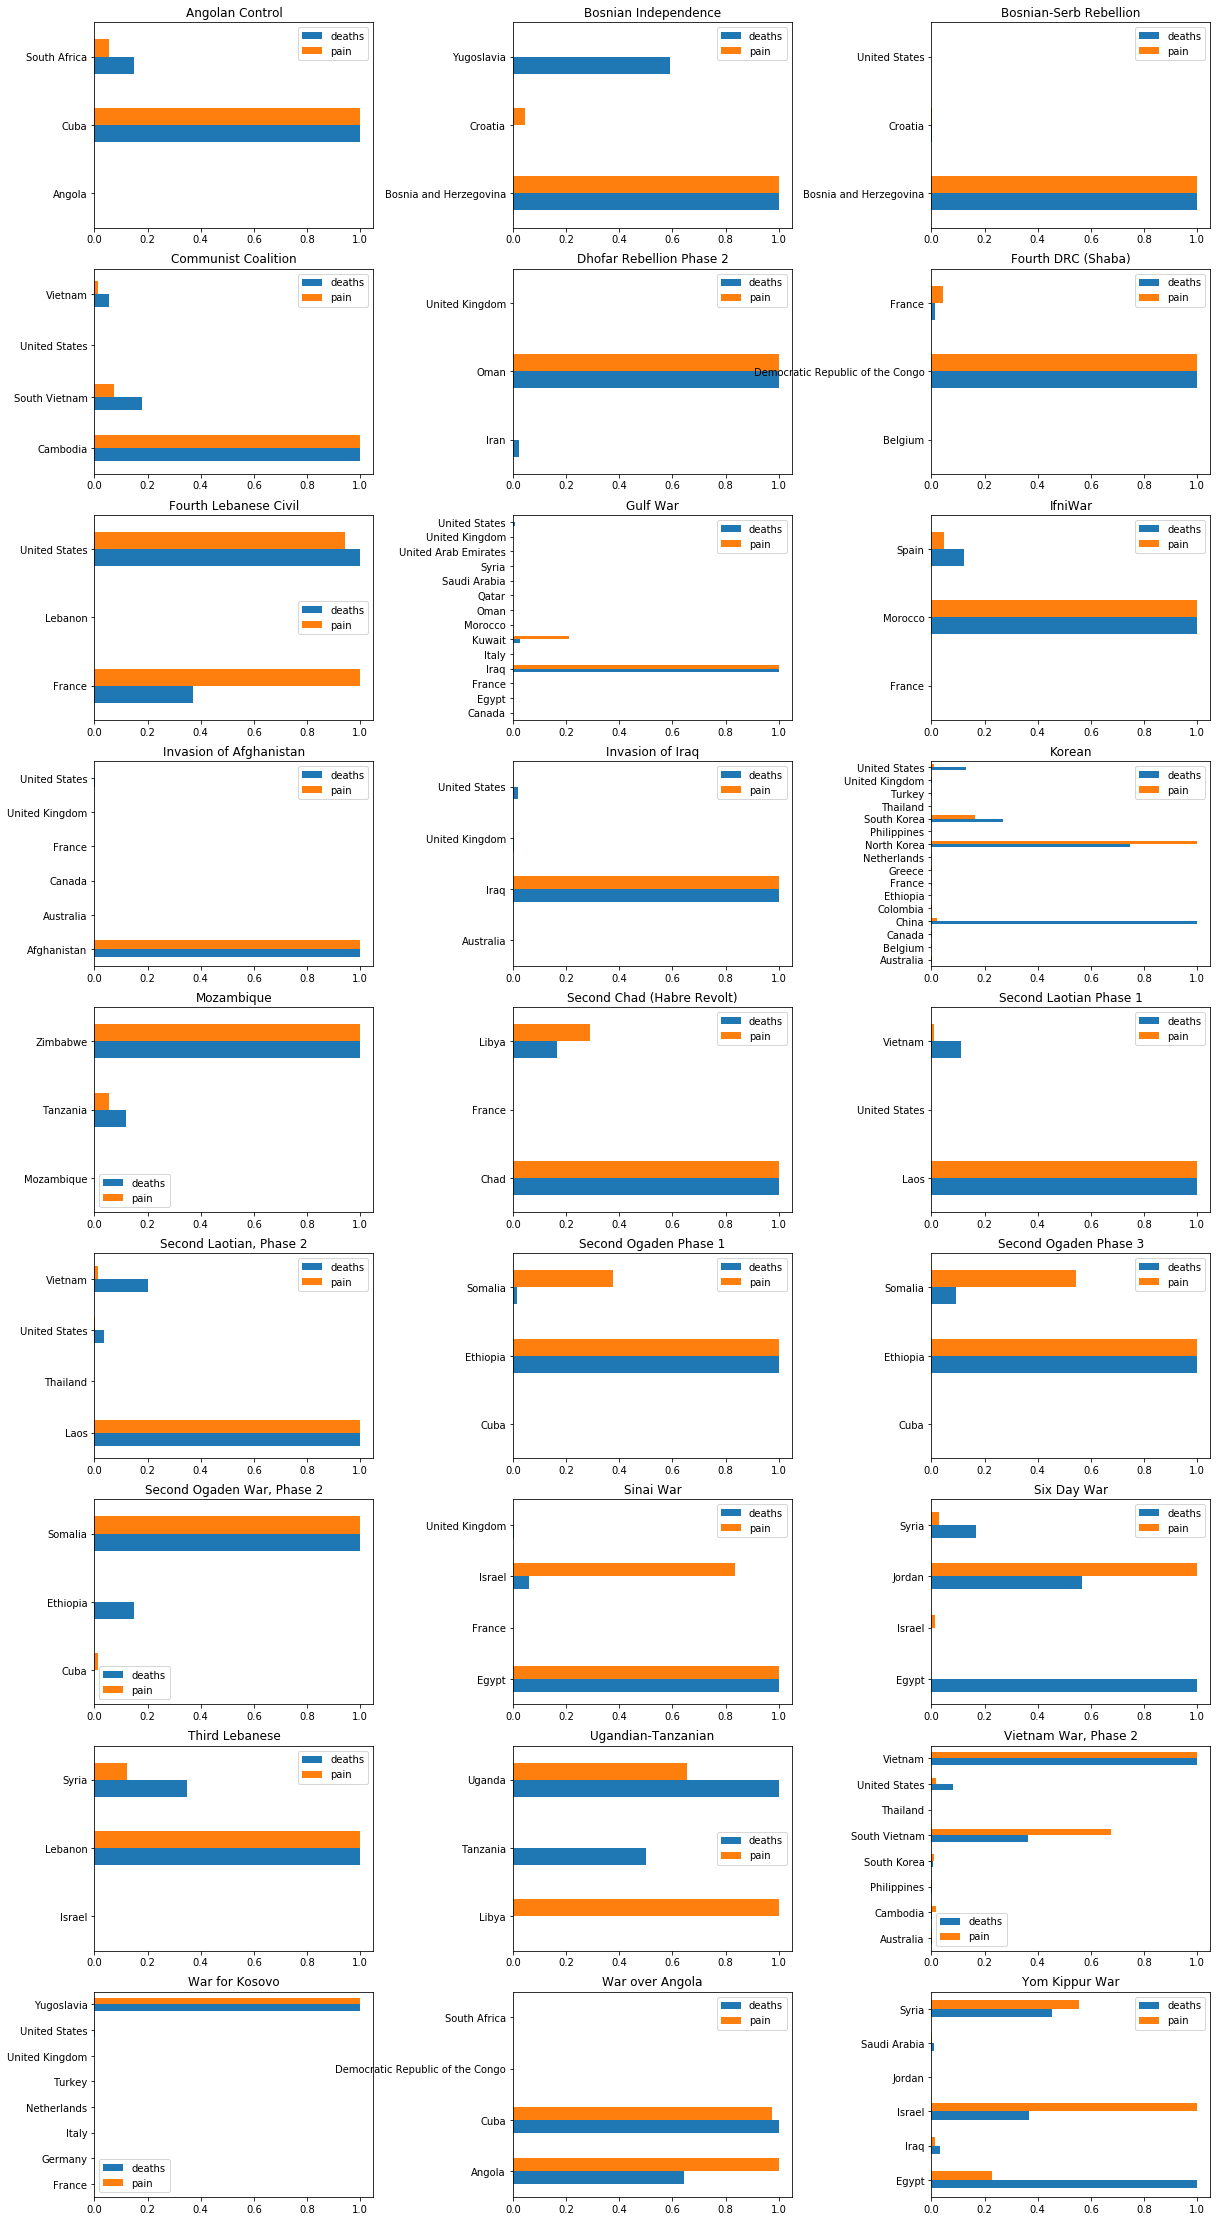

In [292]:
fig55()

In [256]:
# excluding INTRA-state wars from this calculation because those are civil wars, a state
# fighting with itself.  But we're looking at population differences, which come out to 0
# in such cases.  Even though, in reality, different parts of these populations are loyal
# to different sides in the war, we have no data on the numbers involved.
two_party_wars_groups = allwars[['participants', 'war_name', 'file', 'deaths', 'cumdeaths',\
         'state_name', 'side1_name','side2_name','dotpop', 'localpain']]\
          [(allwars.participants < 3) & (allwars.file == 'interstate_wars')]\
.sort_values(['war_name', 'dotpop'], ascending=False).groupby('war_name')

p1 = two_party_wars_groups.first()[['state_name', 'dotpop', 'deaths', 'localpain','cumdeaths']]
p2 = two_party_wars_groups.last()[['state_name', 'dotpop', 'deaths', 'localpain']]
merged = pd.merge(p1, p2, left_index=True, right_index=True)

# quick sanity check.  any negative values here means the groups weren't sorted right
merged['popdiff'] = merged.dotpop_x - merged.dotpop_y
merged['deathdiff'] = merged.deaths_x - merged.deaths_y
merged['paindiff'] = merged.localpain_x - merged.localpain_y

def fig6():
    fig, axs = plt.subplots(2,2, figsize=(14,8))
    merged.plot(kind='scatter', x='cumdeaths', y='popdiff', ax=axs[0][0])
    merged[merged.cumdeaths < 100000]\
           .plot(kind='scatter', x='cumdeaths', y='popdiff', ax=axs[0][1])
        
    merged[merged.cumdeaths < 100000]\
           .plot(kind='scatter', x='deathdiff', y='popdiff', ax=axs[1][0])
    merged[merged.cumdeaths < 100000]\
           .plot(kind='scatter', x='paindiff', y='popdiff', ax=axs[1][1])
        
    axs[1][1].axvline(x=0)
    axs[1][0].axvline(x=0)

What about proportionality?  Is there a pattern when big countries fight with small ones?

The plots below compare differences in population with war deaths, per war.  As earlier, a few outliers make the rest hard to see.  All plots except the one in the upper left corner exclude wars with > 120k deaths.

The first two plots (top row) show that total war deaths have nothing to do with the difference in population sizes among participants.

The second row looks at each side individually. The way to read them is to note that the casualty numbers and pain values of the side with the smaller populations are being subtracted from those values of the side with the larger population.  If the results are < 0, it means that the smaller side had either more deaths or more pain (death/local population).  

These plots show that deaths, and especially deaths in relation to population (lower right plot), are worse on the side with the smaller population.  Further, the odds of having a higher casualty count in the smaller country are also higher when the population difference is higher, though it's not a linear relationship(lower left plot).





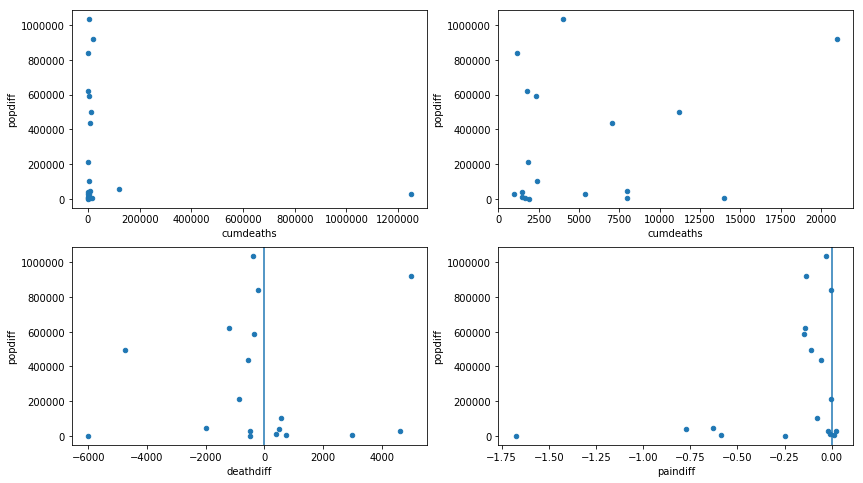

In [257]:
fig6()

In [246]:
inter = allwars[(allwars.year_of_war >= 1950) & (allwars.cumdeaths < 400000) \
                & (allwars.localpain > .00001) & (allwars.file == 'interstate_wars')]

intra = allwars[(allwars.year_of_war >= 1950) & (allwars.file == 'intrastate_wars')]

im = inter.cumdeaths.mean()

def fig7():
    fig, axs = plt.subplots(1,2, figsize=(12,6))


    sns.regplot(x="cumdeaths", y="year_of_war", data=inter, scatter_kws={'s':4}, ax=axs[0]);
    axs[0].set_title('inter - state wars')
    sns.regplot(x="cumdeaths", y="year_of_war", data=intra, scatter_kws={'s':4}, ax=axs[1]);
    axs[1].set_title('intra - state wars');
    
    print 'INTER-state war deaths (1950 - 2007)'
    print "                  mean", round(inter.cumdeaths.mean(), 2)
    print '                   sum', round(inter.cumdeaths.sum(), 2)

    print '--------------------------------------'
    print 'INTRA-state war deaths (1950 - 2007)'
    print "                  mean", round(intra.cumdeaths.mean(), 2)
    print '                   sum', round(intra.cumdeaths.sum(), 2)

    print '\n'

Intra-state wars / civil wars / have a reputation for being more brutal.
The two plots below show the total number of deaths per year from inter-state and 
intra-state wars for the period, excluding the familiar outliers.

Even with those exclusions, inter-state wars have higher average casualties than intra-state wars.  But, with those exclusions, intra-state wars kill more people overall because there are more of them.  

INTER-state war deaths (1950 - 2007)
                  mean 12744.7
                   sum 1108789.0
--------------------------------------
INTRA-state war deaths (1950 - 2007)
                  mean 7314.7
                   sum 1733584.0




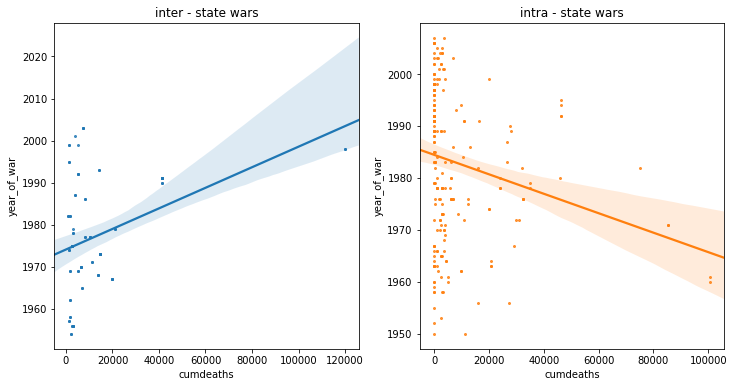

In [247]:
fig7()

In [248]:
# who fights the most wars
#freq = allwars.state_name[allwars['state_name'].notnull()].value_counts().to_frame()# oh well, they're the same
freq = allwars[['state_name', 'war_name']].groupby('state_name').size().to_frame().sort_values(0, ascending=False)
freq.rename(columns={0:'state_name'}, inplace=True)

# mean of localpain by country
pain_index = allwars[['state_name', 'localpain']][allwars['state_name'].notnull()]\
          .groupby('state_name').mean()

pf = pd.merge(freq, pain_index, left_index=True, right_index=True)
pf.rename(columns={'localpain':'localpain_mean', 'state_name':'war_frequency'}, inplace=True)
#strategic_powers['power_index'] = strategic_powers.war_frequency * strategic_powers.inverse_pain



def fig8():
    fig, ax = plt.subplots(1,1, figsize=(20,5))
    pf.sort_values('war_frequency', ascending=False).plot(kind='bar', ax=ax);
    ax.set_title('war frequency alongside the mean of casualties/population, sorted by war frequency')
    
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    pf.sort_values('war_frequency', ascending=False).plot(kind='scatter', \
                                    x='war_frequency', y='localpain_mean', ax=axs[0])
    axs[0].set_title('war frequency vs. casualties/population')
    
    pf[(pf.localpain_mean < 30) & (pf.war_frequency < 12)]\
               .sort_values('war_frequency', ascending=False).plot(kind='scatter', \
                x='war_frequency', y='localpain_mean', ax=axs[1])
    axs[1].set_title('same as to left with outliers removed for better visibility')
    

Which countries fight the most wars?  

In general, great powers fight more wars. They also, as we have seen previously, suffer less from them.  

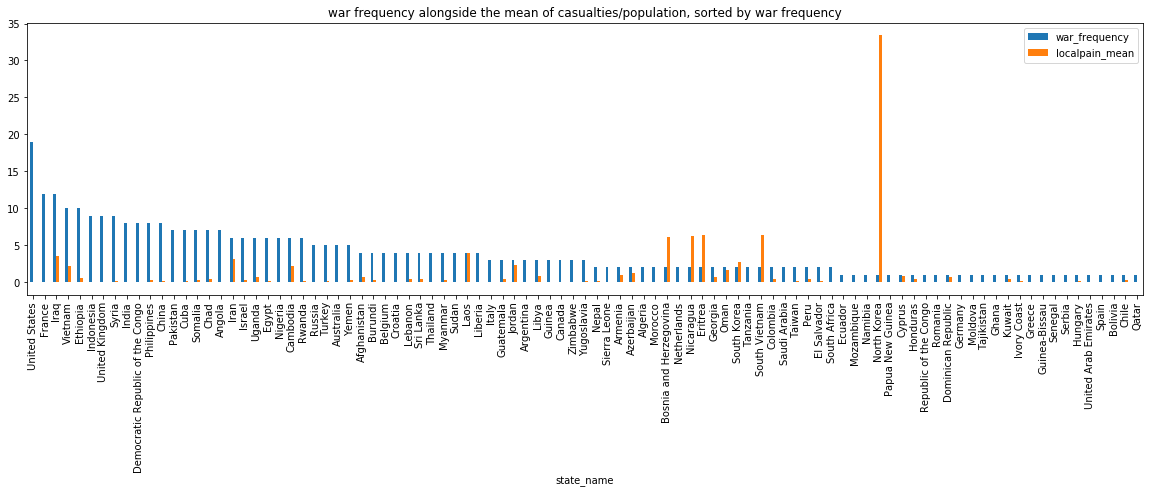

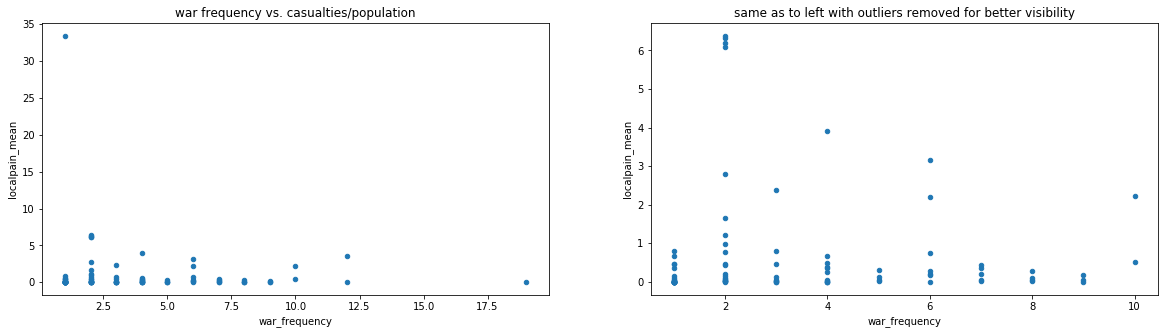

In [249]:
fig8()

In [284]:
#allwars[['state_name', 'localpain']][allwars['state_name'] == 'Italy']
#inverse_pain_index[inverse_pain_index.index == 'Italy']

In [282]:
def scalize(s):
    s = (s - s.min())/(s.max() - s.min())
    return s

# some of the localpain values in allwars come out negative because the numbers in the cells
# from which they're calculated are codes rather than casualty numbers.  That just means we 
# don't have real values.  Make those 1 so they don't cause problems as numerators below
allwars.localpain
lp_ind = allwars[(allwars.localpain < 0)].index
allwars = allwars.set_value(lp_ind, 'localpain', 1)



## ---------------    inverse pain rating

# mean of localpain for each country
inverse_pain_index = allwars[['state_name', 'localpain']][allwars['state_name'].notnull()]\
          .groupby('state_name').mean()

# make them usable as denominators in the next step. 
# some of these are fractions < 1, so push everything up a bit
inverse_pain_index.localpain = pain_index.localpain + 1
inverse_pain_index.mask(pain_index.localpain.isnull(), 1, inplace=True)
####   pain_index.sort_index().plot()

# invert and normalize
inverse_pain_index.localpain = 1/(inverse_pain_index.localpain)

## ---------------    war frequency

# borrowing from the frequency table above
fr = freq.copy()

# normalize war frequency to get a rating
fr.state_name = scalize(fr.state_name)
# fr.state_name.sort_index().plot()

## ---------------    strategic powers rating

# merge them, rename the columns, then add the parts together to get a strategic_powers rating
strategic_powers = pd.merge(fr, inverse_pain_index, left_index=True, right_index=True)
strategic_powers.rename(columns={'localpain':'inverse_pain', 'state_name':'war_frequency'}, inplace=True)
strategic_powers['power_index'] = strategic_powers.war_frequency * strategic_powers.inverse_pain

def fig9():
    fig, ax = plt.subplots(1,1, figsize=(20,5))
    strategic_powers.sort_values('power_index', ascending=False).head(400).plot(kind='bar', ax=ax)
    ax.legend(loc='upper right')

Following through on this observation, and with a little tinkering, here's a "strategic power index" (green bars) that tries to get at which countries use their power for strategic purposes (defined as fighting more while suffering less).  

It doesn't account for the nature of a nation's involvement in a given war (fighting alone, with a coalition, with small or large troop commitments, etc) but, at a glance, it seems to be in the ballpark.  

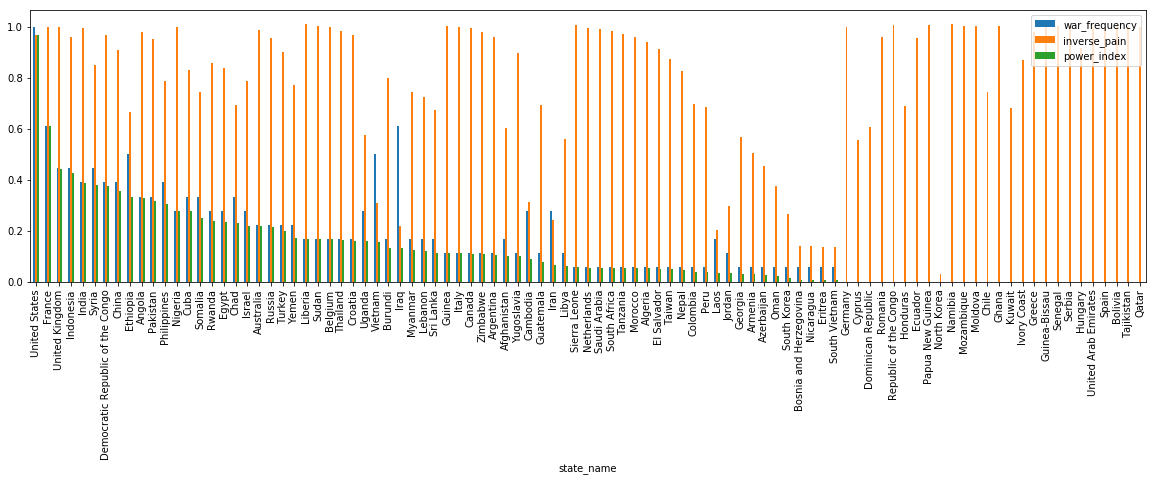

In [285]:
fig9()

In [287]:
# now let's rate wars in terms of strategic_powers involvement
warvalue = allwars[['state_name', 'war_name', 'participants']][allwars.state_name.notnull()]\
                   .pivot_table(index='war_name', columns='state_name', values='participants')
warvalue.fillna(0, inplace=True)
warvalue['rating'] = np.nan

## the table has values for the number of participants.  That's a meaningless number.
## just needed something to make the pivot work.  now replace all those with something useful.
## this rates each war in terms of the strategic rating of its participants
warvalue.mask(warvalue > 0, 1, inplace=True)
for country in warvalue.columns:
    if country in strategic_powers.index:
        warvalue[country] = warvalue[country] * strategic_powers[strategic_powers.index == country]\
                            .power_index.iloc[0]

# proving a rating for the wars themselves
warvalue['rating'] = warvalue.sum(axis=1)
warvalue = warvalue.rating.to_frame()

def fig10():
    fig, ax = plt.subplots(1,1, figsize=(20,5))
    warvalue.sort_values('rating', ascending=False).head(50).plot(kind='bar', ax=ax)
    ax.legend(loc='upper right')
    ax.set_title('wars by their strategic importance')

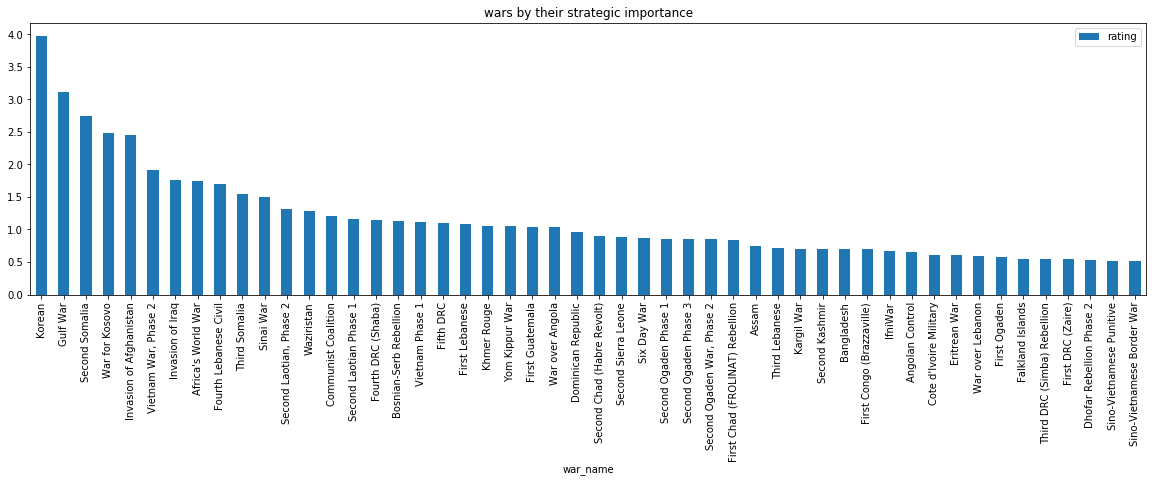

In [288]:
fig10()